# Initialize

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

from model import VAE_priorCategorical, VAE_priorHFM
import metadata as md
from train import train
from datasets import Dataset_HFM, Dataset_pureHFM, MNISTDigit2Dataset
from utilities import sample_images

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizzo Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilizzo NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Utilizzo la CPU")

device = torch.device('cpu')

if device.type == "cuda": 
    torch.cuda.manual_seed(md.seed)
elif device.type == "mps": 
    torch.mps.manual_seed(md.seed)

Utilizzo Apple Silicon GPU (MPS)


# Datasets

## train over ExtendedMNIST

In [9]:
train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )

## train over 2MNIST

In [10]:
dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=32, shuffle=True)
batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=32, shuffle=True)
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([32, 1, 28, 28])
Batch labels shape: torch.Size([32])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([32, 1, 28, 28])
Batch labels shape: torch.Size([32])
All labels are 2: True


## train over MNIST

In [11]:
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )

## train over FashionMNIST

In [5]:
train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=md.batch_size,
    shuffle=False
    )

## train over pureHFM

In [6]:
dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)

## train over expandedHFM

In [6]:
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)

## train over expandedHFM 32-1024

In [5]:
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size=md.batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=md.batch_size,
    shuffle=False
)

# Prior Categorical

## train over Extended_MNIST


In [11]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784



### 8 features


In [ ]:

#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')



#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


 #### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')


 #### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 7

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=7, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 354.4975
Epoch: 1/15, Average loss: 257.1719
Epoch: 1/15, Average loss: 257.1719
Epoch: 2/15, Average loss: 225.2962
Epoch: 2/15, Average loss: 225.2962
Epoch: 3/15, Average loss: 207.9109
Epoch: 3/15, Average loss: 207.9109
Epoch: 4/15, Average loss: 197.5804
Epoch: 4/15, Average loss: 197.5804
Epoch: 5/15, Average loss: 191.0185
Epoch: 5/15, Average loss: 191.0185
Epoch: 6/15, Average loss: 186.4766
Epoch: 6/15, Average loss: 186.4766
Epoch: 7/15, Average loss: 183.1223
Epoch: 7/15, Average loss: 183.1223
Epoch: 8/15, Average loss: 180.7083
Epoch: 8/15, Average loss: 180.7083
Epoch: 9/15, Average loss: 178.7871
Epoch: 9/15, Average loss: 178.7871
Epoch: 10/15, Average loss: 177.4256
Epoch: 10/15, Average loss: 177.4256
Epoch: 11/15, Average loss: 176.2543
Epoch: 11/15, Average loss: 176.2543
Epoch: 12/15, Average loss: 175.2246
Epoch: 12/15, Average loss: 175.2246
Epoch: 13/15, Average loss: 174.4136
Epoch: 13/15, Average loss: 174.4136
Epoch: 14/15, Averag

### 10 features

In [ ]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')



#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


 #### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')




Epoch: 0/15, Average loss: 349.8097
Epoch: 1/15, Average loss: 252.5678
Epoch: 2/15, Average loss: 220.1362
Epoch: 3/15, Average loss: 203.2145
Epoch: 4/15, Average loss: 193.3282
Epoch: 5/15, Average loss: 186.8372
Epoch: 6/15, Average loss: 182.4854
Epoch: 7/15, Average loss: 179.3084
Epoch: 8/15, Average loss: 177.0011
Epoch: 9/15, Average loss: 175.3268
Epoch: 10/15, Average loss: 173.9250
Epoch: 11/15, Average loss: 172.8551
Epoch: 12/15, Average loss: 171.9738
Epoch: 13/15, Average loss: 171.2925
Epoch: 14/15, Average loss: 170.7406
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 350.6189
Epoch: 1/15, Average loss: 250.9468
Epoch: 2/15, Average loss: 217.6095
Epoch: 3/15, Average loss: 200.6092
Epoch: 4/15, Average loss: 190.5887
Epoch: 5/15, Average loss: 183.7372
Epoch: 6/15, Average loss: 178.4993
Epoch: 7/15, Average loss: 174.6541
Epoch: 8/15, Average loss: 171.8537
Epoch: 9/15, Average loss: 169.7876
Epoch: 10/15, Average loss: 167.9942
Epoch: 1

## train over 2Digit_MNIST

In [5]:
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 784


In [6]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld4_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=4, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld4_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 304.0161
Epoch: 1/15, Average loss: 218.2176
Epoch: 2/15, Average loss: 200.2183
Epoch: 3/15, Average loss: 193.5813
Epoch: 4/15, Average loss: 190.6368
Epoch: 5/15, Average loss: 189.0655
Epoch: 6/15, Average loss: 187.8614
Epoch: 7/15, Average loss: 187.0031
Epoch: 8/15, Average loss: 186.1542
Epoch: 9/15, Average loss: 185.7021
Epoch: 10/15, Average loss: 185.1782
Epoch: 11/15, Average loss: 184.6376
Epoch: 12/15, Average loss: 184.3533
Epoch: 13/15, Average loss: 183.8985
Epoch: 14/15, Average loss: 183.5778
Training completato e dati scritti su tensorboard
Parameters saved


In [8]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld4_glog2_ep15_lmb01_dr05_gKLlog2_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=4, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=False).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld4_glog2_ep15_lmb01_dr05_gKLlog2_4hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 252.4005
Epoch: 1/15, Average loss: 250.1789
Epoch: 2/15, Average loss: 250.0696
Epoch: 3/15, Average loss: 250.0042
Epoch: 4/15, Average loss: 249.9637
Epoch: 5/15, Average loss: 249.9323
Epoch: 6/15, Average loss: 249.9188
Epoch: 7/15, Average loss: 233.9203
Epoch: 8/15, Average loss: 212.0527
Epoch: 9/15, Average loss: 205.7089
Epoch: 10/15, Average loss: 200.1853
Epoch: 11/15, Average loss: 195.8478
Epoch: 12/15, Average loss: 193.2903
Epoch: 13/15, Average loss: 191.1994
Epoch: 14/15, Average loss: 189.7921
Training completato e dati scritti su tensorboard
Parameters saved


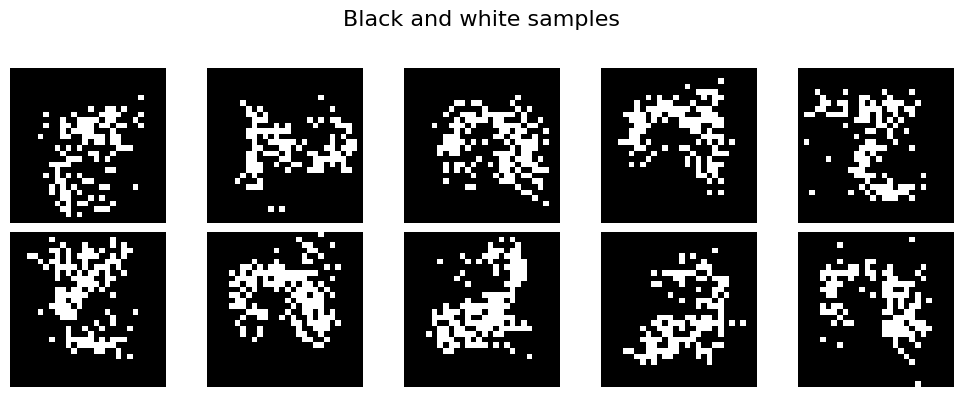

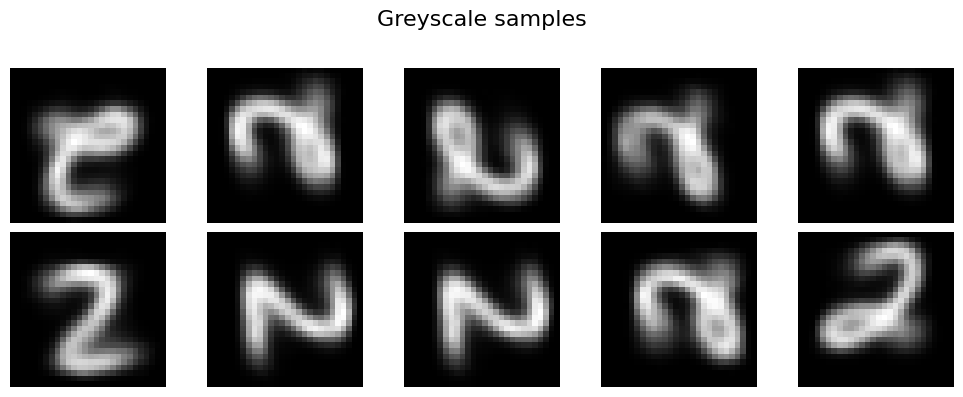

In [7]:
sample_images(my_model)

### 8 features


In [7]:

#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 293.0254
Epoch: 1/15, Average loss: 199.2283
Epoch: 2/15, Average loss: 179.8768
Epoch: 3/15, Average loss: 173.0299
Epoch: 4/15, Average loss: 169.1212
Epoch: 5/15, Average loss: 166.2844
Epoch: 6/15, Average loss: 164.3290
Epoch: 7/15, Average loss: 162.8076
Epoch: 8/15, Average loss: 161.5842
Epoch: 9/15, Average loss: 160.7148
Epoch: 10/15, Average loss: 159.9534
Epoch: 11/15, Average loss: 159.2769
Epoch: 12/15, Average loss: 158.8208
Epoch: 13/15, Average loss: 158.2286
Epoch: 14/15, Average loss: 157.8266
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 293.5113
Epoch: 1/15, Average loss: 198.2328
Epoch: 2/15, Average loss: 178.4778
Epoch: 3/15, Average loss: 170.6506
Epoch: 4/15, Average loss: 165.6475
Epoch: 5/15, Average loss: 162.1394
Epoch: 6/15, Average loss: 159.5660
Epoch: 7/15, Average loss: 157.7338
Epoch: 8/15, Average loss: 156.2479
Epoch: 9/15, Average loss: 155.0138
Epoch: 10/15, Average loss: 153.9606
Epoch: 1

In [8]:


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 317.1253
Epoch: 1/15, Average loss: 254.0380
Epoch: 2/15, Average loss: 250.4241
Epoch: 3/15, Average loss: 249.7298
Epoch: 4/15, Average loss: 249.5778
Epoch: 5/15, Average loss: 249.5387
Epoch: 6/15, Average loss: 249.5223
Epoch: 7/15, Average loss: 249.5062
Epoch: 8/15, Average loss: 249.5075
Epoch: 9/15, Average loss: 249.5052
Epoch: 10/15, Average loss: 249.4995
Epoch: 11/15, Average loss: 249.4920
Epoch: 12/15, Average loss: 249.4916
Epoch: 13/15, Average loss: 249.4944
Epoch: 14/15, Average loss: 249.4895
Training completato e dati scritti su tensorboard
Parameters saved


In [9]:
#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 7

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=7, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 314.7471
Epoch: 1/15, Average loss: 246.3329
Epoch: 2/15, Average loss: 242.4432
Epoch: 3/15, Average loss: 246.4289
Epoch: 4/15, Average loss: 249.6111


KeyboardInterrupt: 

### 10 features

In [11]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')



Epoch: 0/15, Average loss: 289.6640
Epoch: 1/15, Average loss: 193.0851
Epoch: 2/15, Average loss: 173.0547
Epoch: 3/15, Average loss: 165.9744
Epoch: 4/15, Average loss: 162.1465
Epoch: 5/15, Average loss: 159.2105
Epoch: 6/15, Average loss: 156.8267
Epoch: 7/15, Average loss: 154.7964
Epoch: 8/15, Average loss: 153.1571
Epoch: 9/15, Average loss: 151.8358
Epoch: 10/15, Average loss: 150.8027
Epoch: 11/15, Average loss: 149.9243
Epoch: 12/15, Average loss: 149.1409
Epoch: 13/15, Average loss: 148.5724
Epoch: 14/15, Average loss: 147.9692
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 291.2133
Epoch: 1/15, Average loss: 192.8380
Epoch: 2/15, Average loss: 172.2742
Epoch: 3/15, Average loss: 165.7251
Epoch: 4/15, Average loss: 162.3980
Epoch: 5/15, Average loss: 159.8999
Epoch: 6/15, Average loss: 157.8492
Epoch: 7/15, Average loss: 155.8201
Epoch: 8/15, Average loss: 153.9527
Epoch: 9/15, Average loss: 152.0119
Epoch: 10/15, Average loss: 150.3478
Epoch: 1

In [12]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=7, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 318.0827
Epoch: 1/15, Average loss: 254.0073
Epoch: 2/15, Average loss: 250.4167
Epoch: 3/15, Average loss: 249.7302
Epoch: 4/15, Average loss: 249.5816
Epoch: 5/15, Average loss: 249.5373


KeyboardInterrupt: 

## train over MNIST

In [5]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784

### 8 features

In [ ]:

#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST//ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 7

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=7, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 386.3299
Epoch: 1/15, Average loss: 269.6630
Epoch: 2/15, Average loss: 220.6156
Epoch: 3/15, Average loss: 192.3674
Epoch: 4/15, Average loss: 172.4641
Epoch: 5/15, Average loss: 158.6117
Epoch: 6/15, Average loss: 148.8546
Epoch: 7/15, Average loss: 141.7337
Epoch: 8/15, Average loss: 136.4395
Epoch: 9/15, Average loss: 132.2159
Epoch: 10/15, Average loss: 128.9444
Epoch: 11/15, Average loss: 126.1562
Epoch: 12/15, Average loss: 123.7926
Epoch: 13/15, Average loss: 121.9730
Epoch: 14/15, Average loss: 120.2335
Training completato e dati scritti su tensorboard
Parameters saved
Epoch: 0/15, Average loss: 386.8003
Epoch: 1/15, Average loss: 270.2383
Epoch: 2/15, Average loss: 221.5904
Epoch: 3/15, Average loss: 193.3287
Epoch: 4/15, Average loss: 173.1111
Epoch: 5/15, Average loss: 158.6518
Epoch: 6/15, Average loss: 148.4285
Epoch: 7/15, Average loss: 140.9530
Epoch: 8/15, Average loss: 135.4636
Epoch: 9/15, Average loss: 131.2472
Epoch: 10/15, Average loss: 

In [ ]:
#This has been made to check the validity of the kl for 5 hidden layers, as it seems to be an aberrant value.
# Magically, it fixed itself.


#### features = 8, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_1')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=8, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld8_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_1.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 402.5911
Epoch: 1/15, Average loss: 275.8961
Epoch: 2/15, Average loss: 226.4554
Epoch: 3/15, Average loss: 198.4908
Epoch: 4/15, Average loss: 177.8793
Epoch: 5/15, Average loss: 163.3509
Epoch: 6/15, Average loss: 153.2155
Epoch: 7/15, Average loss: 146.2363
Epoch: 8/15, Average loss: 141.0705
Epoch: 9/15, Average loss: 137.0449
Epoch: 10/15, Average loss: 134.0465
Epoch: 11/15, Average loss: 131.8412
Epoch: 12/15, Average loss: 130.0399
Epoch: 13/15, Average loss: 128.2418
Epoch: 14/15, Average loss: 127.0624
Training completato e dati scritti su tensorboard
Parameters saved


### 10 features

In [6]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 7

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=7, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_7hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 382.6704
Epoch: 1/15, Average loss: 269.1358
Epoch: 2/15, Average loss: 219.8319
Epoch: 3/15, Average loss: 190.9535
Epoch: 4/15, Average loss: 170.5004
Epoch: 5/15, Average loss: 156.3013
Epoch: 6/15, Average loss: 146.3802
Epoch: 7/15, Average loss: 139.2002
Epoch: 8/15, Average loss: 133.7200
Epoch: 9/15, Average loss: 129.5677
Epoch: 10/15, Average loss: 126.1323
Epoch: 11/15, Average loss: 123.3453
Epoch: 12/15, Average loss: 121.0505
Epoch: 13/15, Average loss: 119.1494
Epoch: 14/15, Average loss: 117.6010
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 384.0852
Epoch: 1/15, Average loss: 267.8581
Epoch: 2/15, Average loss: 218.3796
Epoch: 3/15, Average loss: 189.0615
Epoch: 4/15, Average loss: 168.0823
Epoch: 5/15, Average loss: 153.4838
Epoch: 6/15, Average loss: 143.4466
Epoch: 7/15, Average loss: 136.2004
Epoch: 8/15, Average loss: 130.9332
Epoch: 9/15, Average loss: 126.8407
Epoch: 10/15, Average loss: 123.6340
Epoch: 1

## train over expandedHFM 16-1024

In [ ]:
train_loader = train_loader_expandedHFM
val_loader = val_loader_expandedHFM
input_dim = 1024

### latent_dim = 32

In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_1hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_1hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 369.4557
Epoch: 1/20, Average loss: 253.0922
Epoch: 2/20, Average loss: 202.8551
Epoch: 3/20, Average loss: 172.7191
Epoch: 4/20, Average loss: 152.2356
Epoch: 5/20, Average loss: 137.6990
Epoch: 6/20, Average loss: 126.6692
Epoch: 7/20, Average loss: 118.0560
Epoch: 8/20, Average loss: 111.1311
Epoch: 9/20, Average loss: 105.9597
Epoch: 10/20, Average loss: 101.8351
Epoch: 11/20, Average loss: 98.4729
Epoch: 12/20, Average loss: 95.4016
Epoch: 13/20, Average loss: 92.9106
Epoch: 14/20, Average loss: 90.9402
Epoch: 15/20, Average loss: 89.1270
Epoch: 16/20, Average loss: 87.6784
Epoch: 17/20, Average loss: 86.5530
Epoch: 18/20, Average loss: 85.3882
Epoch: 19/20, Average loss: 84.4254
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 32, g_model = log(2), epochs = 20, hidden layers = 2, decrease_rate = 0.5, g_HFM per KL = log2

In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_2hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_2hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 393.1789
Epoch: 1/20, Average loss: 300.7643
Epoch: 2/20, Average loss: 241.3813
Epoch: 3/20, Average loss: 207.7646
Epoch: 4/20, Average loss: 179.9620
Epoch: 5/20, Average loss: 160.1453
Epoch: 6/20, Average loss: 144.9132
Epoch: 7/20, Average loss: 133.3975
Epoch: 8/20, Average loss: 125.1795
Epoch: 9/20, Average loss: 118.3757
Epoch: 10/20, Average loss: 112.1573
Epoch: 11/20, Average loss: 107.3208
Epoch: 12/20, Average loss: 103.3839
Epoch: 13/20, Average loss: 99.9120
Epoch: 14/20, Average loss: 96.7396
Epoch: 15/20, Average loss: 94.4459
Epoch: 16/20, Average loss: 92.6706
Epoch: 17/20, Average loss: 90.7141
Epoch: 18/20, Average loss: 88.7004
Epoch: 19/20, Average loss: 87.0102
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 32, g_model = log(2), epochs = 20, hidden layers = 3, decrease_rate = 0.5, g_HFM per KL = log2

In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_3hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_3hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 399.2147
Epoch: 1/20, Average loss: 324.6712
Epoch: 2/20, Average loss: 275.4050
Epoch: 3/20, Average loss: 239.8818
Epoch: 4/20, Average loss: 216.3649
Epoch: 5/20, Average loss: 198.0273
Epoch: 6/20, Average loss: 182.2649
Epoch: 7/20, Average loss: 170.8574
Epoch: 8/20, Average loss: 162.9704
Epoch: 9/20, Average loss: 154.4810
Epoch: 10/20, Average loss: 146.7258
Epoch: 11/20, Average loss: 139.4719
Epoch: 12/20, Average loss: 134.2167
Epoch: 13/20, Average loss: 129.6427
Epoch: 14/20, Average loss: 125.4191
Epoch: 15/20, Average loss: 121.2396
Epoch: 16/20, Average loss: 118.2277
Epoch: 17/20, Average loss: 115.6689
Epoch: 18/20, Average loss: 112.8884
Epoch: 19/20, Average loss: 111.4160
Training completato e dati scritti su tensorboard
Parameters saved


#### features = 32, g_model = log(2), epochs = 20, hidden layers = 4, decrease_rate = 0.5, g_HFM per KL = log2

In [ ]:
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/runs/discrete_VAE/prior_HFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_4hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_4hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 405.6318
Epoch: 1/20, Average loss: 331.2717
Epoch: 2/20, Average loss: 293.0868
Epoch: 3/20, Average loss: 260.4425
Epoch: 4/20, Average loss: 235.3888
Epoch: 5/20, Average loss: 217.5635
Epoch: 6/20, Average loss: 207.8059
Epoch: 7/20, Average loss: 200.4518
Epoch: 8/20, Average loss: 194.3792
Epoch: 9/20, Average loss: 189.3980
Epoch: 10/20, Average loss: 184.9584
Epoch: 11/20, Average loss: 179.7132
Epoch: 12/20, Average loss: 174.9633
Epoch: 13/20, Average loss: 170.7941
Epoch: 14/20, Average loss: 167.3850
Epoch: 15/20, Average loss: 164.2246
Epoch: 16/20, Average loss: 161.3431
Epoch: 17/20, Average loss: 159.5106
Epoch: 18/20, Average loss: 156.5435
Epoch: 19/20, Average loss: 154.0239
Training completato e dati scritti su tensorboard
Parameters saved


In [ ]:
# 5 hidden layers
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_5hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.5, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM/ld32_glog2_ep15_lmb01_dr05_gKLlog2_5hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 408.6061
Epoch: 1/20, Average loss: 368.8077
Epoch: 2/20, Average loss: 357.9416
Epoch: 3/20, Average loss: 353.8225
Epoch: 4/20, Average loss: 351.9900
Epoch: 5/20, Average loss: 351.0825
Epoch: 6/20, Average loss: 350.5930
Epoch: 7/20, Average loss: 350.3083
Epoch: 8/20, Average loss: 350.1508
Epoch: 9/20, Average loss: 350.0325
Epoch: 10/20, Average loss: 349.9596
Epoch: 11/20, Average loss: 349.9249
Epoch: 12/20, Average loss: 349.8968
Epoch: 13/20, Average loss: 349.8726
Epoch: 14/20, Average loss: 349.8558
Epoch: 15/20, Average loss: 349.8398
Epoch: 16/20, Average loss: 349.8369
Epoch: 17/20, Average loss: 349.8276
Epoch: 18/20, Average loss: 349.8294
Epoch: 19/20, Average loss: 349.8175
Training completato e dati scritti su tensorboard
Parameters saved


In [ ]:
# 6 hidden layers
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_HFM/expandedHFM/ld32_glog2_ep15_lmb01_dr06_gKLlog2_6hl_0')
my_model = VAE_priorHFM(input_dim=input_dim, latent_dim=32, g=np.log(2), decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, _lambda=0.1, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, calculate_KL_HFM=True)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorHFM/expandedHFM/ld32_glog2_ep15_lmb01_dr06_gKLlog2_6hl_0.pth')
print('Parameters saved')

Epoch: 0/20, Average loss: 408.4123
Epoch: 1/20, Average loss: 369.0100
Epoch: 2/20, Average loss: 357.9196
Epoch: 3/20, Average loss: 353.9314
Epoch: 4/20, Average loss: 351.9628
Epoch: 5/20, Average loss: 351.0653
Epoch: 6/20, Average loss: 350.5855
Epoch: 7/20, Average loss: 350.3135
Epoch: 8/20, Average loss: 350.1441
Epoch: 9/20, Average loss: 350.0360
Epoch: 10/20, Average loss: 349.9780
Epoch: 11/20, Average loss: 349.9259
Epoch: 12/20, Average loss: 349.9004
Epoch: 13/20, Average loss: 349.8688
Epoch: 14/20, Average loss: 349.8592
Epoch: 15/20, Average loss: 349.8426
Epoch: 16/20, Average loss: 349.8388
Epoch: 17/20, Average loss: 349.8324
Epoch: 18/20, Average loss: 349.8224
Epoch: 19/20, Average loss: 349.8243
Training completato e dati scritti su tensorboard
Parameters saved


## CoarseGrainMNIST

### 2MNIST

In [12]:
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 784


#### 10 features

In [6]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 289.6801
Epoch: 1/15, Average loss: 193.2628
Epoch: 2/15, Average loss: 173.1857
Epoch: 3/15, Average loss: 166.2264
Epoch: 4/15, Average loss: 162.2819
Epoch: 5/15, Average loss: 159.5451
Epoch: 6/15, Average loss: 157.3774
Epoch: 7/15, Average loss: 155.7244
Epoch: 8/15, Average loss: 154.3177
Epoch: 9/15, Average loss: 153.0372
Epoch: 10/15, Average loss: 152.0837
Epoch: 11/15, Average loss: 151.2058
Epoch: 12/15, Average loss: 150.6141
Epoch: 13/15, Average loss: 149.9940
Epoch: 14/15, Average loss: 149.4595
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 290.8905
Epoch: 1/15, Average loss: 192.6489
Epoch: 2/15, Average loss: 171.9591
Epoch: 3/15, Average loss: 165.0285
Epoch: 4/15, Average loss: 161.3574
Epoch: 5/15, Average loss: 158.6042
Epoch: 6/15, Average loss: 156.4119
Epoch: 7/15, Average loss: 154.2437
Epoch: 8/15, Average loss: 152.3802
Epoch: 9/15, Average loss: 150.4624
Epoch: 10/15, Average loss: 148.9291
Epoch: 1

#### 15 features

In [13]:
#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/ld15_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 284.8414
Epoch: 1/15, Average loss: 183.1887
Epoch: 2/15, Average loss: 160.9913
Epoch: 3/15, Average loss: 153.3714
Epoch: 4/15, Average loss: 149.6740
Epoch: 5/15, Average loss: 147.1825
Epoch: 6/15, Average loss: 145.0476
Epoch: 7/15, Average loss: 143.0832
Epoch: 8/15, Average loss: 141.3419
Epoch: 9/15, Average loss: 139.7237
Epoch: 10/15, Average loss: 138.2031
Epoch: 11/15, Average loss: 137.0340
Epoch: 12/15, Average loss: 135.8692
Epoch: 13/15, Average loss: 135.0475
Epoch: 14/15, Average loss: 134.2537
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 287.2679
Epoch: 1/15, Average loss: 183.3102
Epoch: 2/15, Average loss: 159.8067
Epoch: 3/15, Average loss: 151.8794
Epoch: 4/15, Average loss: 148.0233
Epoch: 5/15, Average loss: 145.5684
Epoch: 6/15, Average loss: 143.8484
Epoch: 7/15, Average loss: 142.2859
Epoch: 8/15, Average loss: 140.7207
Epoch: 9/15, Average loss: 139.1885
Epoch: 10/15, Average loss: 137.8671
Epoch: 1

### MNIST

In [14]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784

#### 10 features

In [11]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 133.2970
Epoch: 1/15, Average loss: 122.0446
Epoch: 2/15, Average loss: 118.3386
Epoch: 3/15, Average loss: 116.1568
Epoch: 4/15, Average loss: 114.5595
Epoch: 5/15, Average loss: 113.3461
Epoch: 6/15, Average loss: 112.3307
Epoch: 7/15, Average loss: 111.6382


#### 15 features

In [15]:
#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld15_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/2MNIST/ld15_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 118.9974
Epoch: 1/15, Average loss: 108.9178
Epoch: 2/15, Average loss: 105.5291
Epoch: 3/15, Average loss: 103.4321
Epoch: 4/15, Average loss: 102.0191
Epoch: 5/15, Average loss: 100.9225
Epoch: 6/15, Average loss: 100.1128
Epoch: 7/15, Average loss: 99.4753
Epoch: 8/15, Average loss: 98.8654
Epoch: 9/15, Average loss: 98.3422
Epoch: 10/15, Average loss: 97.9134
Epoch: 11/15, Average loss: 97.4991
Epoch: 12/15, Average loss: 97.2033
Epoch: 13/15, Average loss: 96.9071
Epoch: 14/15, Average loss: 96.6482
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 117.3612
Epoch: 1/15, Average loss: 107.0709
Epoch: 2/15, Average loss: 103.5259
Epoch: 3/15, Average loss: 101.2345
Epoch: 4/15, Average loss: 99.6001
Epoch: 5/15, Average loss: 98.1619
Epoch: 6/15, Average loss: 97.1757
Epoch: 7/15, Average loss: 96.2539
Epoch: 8/15, Average loss: 95.5477
Epoch: 9/15, Average loss: 94.8823
Epoch: 10/15, Average loss: 94.2359
Epoch: 11/15, Average l

### EMNIST

In [16]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784

#### 10 features

In [14]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 198.2102
Epoch: 1/15, Average loss: 182.7440
Epoch: 2/15, Average loss: 178.3392
Epoch: 3/15, Average loss: 175.9371
Epoch: 4/15, Average loss: 174.3433
Epoch: 5/15, Average loss: 173.1451
Epoch: 6/15, Average loss: 172.2648
Epoch: 7/15, Average loss: 171.4805
Epoch: 8/15, Average loss: 170.9616
Epoch: 9/15, Average loss: 170.4049
Epoch: 10/15, Average loss: 169.9646
Epoch: 11/15, Average loss: 169.6006
Epoch: 12/15, Average loss: 169.3137
Epoch: 13/15, Average loss: 168.9561
Epoch: 14/15, Average loss: 168.6767
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 191.4708
Epoch: 1/15, Average loss: 175.8902
Epoch: 2/15, Average loss: 171.7526
Epoch: 3/15, Average loss: 169.3644
Epoch: 4/15, Average loss: 167.7059
Epoch: 5/15, Average loss: 166.3757
Epoch: 6/15, Average loss: 165.3819
Epoch: 7/15, Average loss: 164.5822
Epoch: 8/15, Average loss: 163.8546
Epoch: 9/15, Average loss: 163.2931
Epoch: 10/15, Average loss: 162.7565
Epoch: 1

#### 15 features

In [17]:
#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 15, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=15, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/MNIST/ld15_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/CoarseGrainMNIST/EMNIST/ld15_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 178.4766
Epoch: 1/15, Average loss: 163.7615
Epoch: 2/15, Average loss: 159.6368
Epoch: 3/15, Average loss: 157.4472
Epoch: 4/15, Average loss: 155.9564
Epoch: 5/15, Average loss: 154.7375
Epoch: 6/15, Average loss: 153.9053
Epoch: 7/15, Average loss: 153.1358
Epoch: 8/15, Average loss: 152.5865
Epoch: 9/15, Average loss: 152.1161
Epoch: 10/15, Average loss: 151.6140
Epoch: 11/15, Average loss: 151.2042
Epoch: 12/15, Average loss: 150.8507
Epoch: 13/15, Average loss: 150.5132
Epoch: 14/15, Average loss: 150.2438
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 172.4355
Epoch: 1/15, Average loss: 158.1250
Epoch: 2/15, Average loss: 154.2267
Epoch: 3/15, Average loss: 151.8399
Epoch: 4/15, Average loss: 150.1762
Epoch: 5/15, Average loss: 149.0276
Epoch: 6/15, Average loss: 148.0015
Epoch: 7/15, Average loss: 147.2197
Epoch: 8/15, Average loss: 146.5538
Epoch: 9/15, Average loss: 145.9382
Epoch: 10/15, Average loss: 145.4336
Epoch: 1

## FineGrainMNIST


### EMNIST

In [15]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784


In [16]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')


Epoch: 0/15, Average loss: 350.1548
Epoch: 1/15, Average loss: 253.1009
Epoch: 2/15, Average loss: 220.7762
Epoch: 3/15, Average loss: 203.9781
Epoch: 4/15, Average loss: 193.5875
Epoch: 5/15, Average loss: 186.7863
Epoch: 6/15, Average loss: 182.2406
Epoch: 7/15, Average loss: 179.1544
Epoch: 8/15, Average loss: 176.9054
Epoch: 9/15, Average loss: 175.2276
Epoch: 10/15, Average loss: 174.0070
Epoch: 11/15, Average loss: 172.9156
Epoch: 12/15, Average loss: 171.9834
Epoch: 13/15, Average loss: 171.3669
Epoch: 14/15, Average loss: 170.7154
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 352.0988
Epoch: 1/15, Average loss: 251.0358
Epoch: 2/15, Average loss: 217.2974
Epoch: 3/15, Average loss: 200.0545
Epoch: 4/15, Average loss: 189.6971
Epoch: 5/15, Average loss: 182.8278
Epoch: 6/15, Average loss: 177.8364
Epoch: 7/15, Average loss: 174.0655
Epoch: 8/15, Average loss: 171.3912
Epoch: 9/15, Average loss: 169.0858
Epoch: 10/15, Average loss: 167.4931
Epoch: 1

### MNIST

In [17]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784


In [18]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/EMNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 128.8488
Epoch: 1/15, Average loss: 118.9810
Epoch: 2/15, Average loss: 115.5914
Epoch: 3/15, Average loss: 113.6978
Epoch: 4/15, Average loss: 112.2368
Epoch: 5/15, Average loss: 111.3334
Epoch: 6/15, Average loss: 110.5636
Epoch: 7/15, Average loss: 109.7967
Epoch: 8/15, Average loss: 109.3749
Epoch: 9/15, Average loss: 108.9270
Epoch: 10/15, Average loss: 108.5444
Epoch: 11/15, Average loss: 108.2124
Epoch: 12/15, Average loss: 107.9081
Epoch: 13/15, Average loss: 107.7173
Epoch: 14/15, Average loss: 107.4304
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 123.7543
Epoch: 1/15, Average loss: 113.4090
Epoch: 2/15, Average loss: 110.3765
Epoch: 3/15, Average loss: 108.4472
Epoch: 4/15, Average loss: 107.0033
Epoch: 5/15, Average loss: 106.0164
Epoch: 6/15, Average loss: 105.1018
Epoch: 7/15, Average loss: 104.4306
Epoch: 8/15, Average loss: 103.9221
Epoch: 9/15, Average loss: 103.5604
Epoch: 10/15, Average loss: 103.0635
Epoch: 1

### 2MNIST

In [19]:
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 784


In [20]:
#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 1

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=1, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_1hl_0.pth')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 2

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=2, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_2hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layer = 3

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=3, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_NL_3hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.5, g_HFM per KL = log2, hidden layers = 4

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.5, device=device, num_hidden_layers=4, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr05_gKLlog2_LN_4hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.55, g_HFM per KL = log2, hidden layers = 5

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.55, device=device, num_hidden_layers=5, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr055_gKLlog2_NL_5hl_0.pth')
print('Parameters saved')


#### features = 10, g_model = log(2), epochs = 15, decrease_rate = 0.6, g_HFM per KL = log2, hidden layers = 6

writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/runs/prior_Categorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0')
my_model = VAE_priorCategorical(input_dim=input_dim, latent_dim=10, categorical_dim=2, decrease_rate=0.6, device=device, num_hidden_layers=6, LayerNorm=True).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth', map_location=device))
optimizer = optim.Adam(my_model.parameters(), lr=md.learning_rate)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device, epochs=15, _lambda=0.1)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/Architetture/VAE/discrete/models_parameters/priorCategorical/FineGrainMNIST/2MNIST/ld10_glog2_ep15_lmb01_dr06_gKLlog2_NL_6hl_0.pth')
print('Parameters saved')

Epoch: 0/15, Average loss: 168.1074
Epoch: 1/15, Average loss: 157.9048
Epoch: 2/15, Average loss: 154.9265
Epoch: 3/15, Average loss: 153.2129
Epoch: 4/15, Average loss: 151.9832
Epoch: 5/15, Average loss: 150.9830
Epoch: 6/15, Average loss: 150.3146
Epoch: 7/15, Average loss: 149.7127
Epoch: 8/15, Average loss: 149.1699
Epoch: 9/15, Average loss: 148.6808
Epoch: 10/15, Average loss: 148.3465
Epoch: 11/15, Average loss: 147.9847
Epoch: 12/15, Average loss: 147.6339
Epoch: 13/15, Average loss: 147.2490
Epoch: 14/15, Average loss: 146.8601
Training completato e dati scritti su tensorboard
Epoch: 0/15, Average loss: 161.4670
Epoch: 1/15, Average loss: 150.4652
Epoch: 2/15, Average loss: 147.3623
Epoch: 3/15, Average loss: 145.4953
Epoch: 4/15, Average loss: 144.2479
Epoch: 5/15, Average loss: 143.1333
Epoch: 6/15, Average loss: 142.4476
Epoch: 7/15, Average loss: 141.6326
Epoch: 8/15, Average loss: 140.9852
Epoch: 9/15, Average loss: 140.5891
Epoch: 10/15, Average loss: 140.1519
Epoch: 1

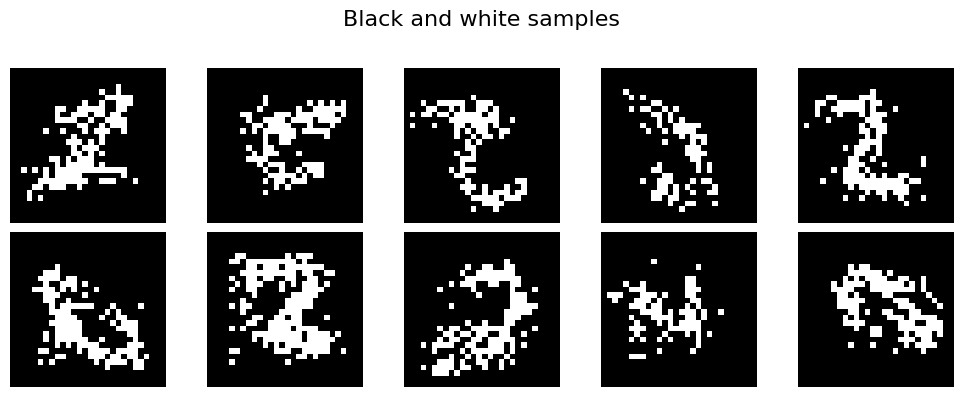

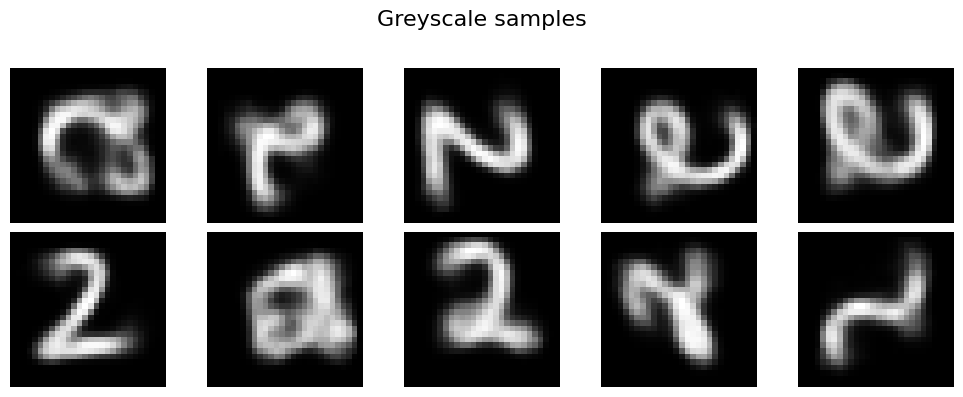

In [25]:
sample_images(my_model)